# SI 618 Project - Analysis

## Project Title: **Customer Insights and Segmentation from Amazon Book Reviews**
### *ChengYu Ko*

## Data Loading, Feature Engineering, and Natural Language Processing

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind
from statsmodels.formula.api import ols
import spacy
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem import WordNetLemmatizer
import string
import contractions
import re

In [2]:
# Read the CSV files
reviews_books = pd.read_csv('reviews_books.csv')

- #### Aggregate the rare categories in `categories` to top 10

In [3]:
# Replace NaN values in 'categories' with 'Unknown'
reviews_books['categories'].fillna('Unknown', inplace=True)

# Count the frequency of each category
category_counts = reviews_books['categories'].value_counts()

# Set the threshold for the top N most frequent categories
top_n = 10

# Get the top N most frequent categories
top_categories = category_counts.head(top_n).index.tolist()

# Aggregate remaining categories into 'Other'
reviews_books['categories'] = reviews_books['categories'].apply(lambda x: x if x in top_categories else 'Other')

# Replace "Unknown" with "Other" in the 'categories' column
reviews_books['categories'].replace('Unknown', 'Other', inplace=True)

- #### Aggregate the rare publishers in `publisher` to top 10

In [4]:
# Replace NaN values in 'publisher' with 'Unknown'
reviews_books['publisher'].fillna('Unknown', inplace=True)

# Count the frequency of each publisher
publisher_counts = reviews_books['publisher'].value_counts()

# Set the threshold for the top N most frequent publishers
top_n = 10

# Get the top N most frequent publishers
top_publishers = publisher_counts.head(top_n).index.tolist()

# Aggregate remaining publishers into 'Other'
reviews_books['publisher'] = reviews_books['publisher'].apply(lambda x: x if x in top_publishers else 'Other')

# Replace "Unknown" with "Other" in the 'publishers' column
reviews_books['publisher'].replace('Unknown', 'Other', inplace=True)

- #### Aggregate the rare authors in `authors` to top 10

In [5]:
# Replace NaN values in 'authors' with 'Unknown'
reviews_books['authors'].fillna('Unknown', inplace=True)

# Count the frequency of each author
author_counts = reviews_books['authors'].value_counts()

# Set the threshold for the top N most frequent authors
top_n = 10

# Get the top N most frequent authors
top_authors = author_counts.head(top_n).index.tolist()

# Aggregate remaining authors into 'Other'
reviews_books['authors'] = reviews_books['authors'].apply(lambda x: x if x in top_authors else 'Other')

# Replace "Unknown" with "Other" in the 'authors' column
reviews_books['authors'].replace('Unknown', 'Other', inplace=True)

- #### Create the word count features for `review/summary` and `review/text`

In [6]:
# Count the number of words in the 'review/summary' variable
reviews_books['summary_count'] = reviews_books['review/summary'].apply(lambda x: len(str(x).split()))

# Count the number of words in the 'review/text' variable
reviews_books['text_count'] = reviews_books['review/text'].apply(lambda x: len(str(x).split()))

- #### Convert the format of `helpfulness`

In [7]:
# Define a function to convert the 'helpfulness' format
def convert_helpfulness(helpfulness):
    try:
        # Split the string by '/' and convert to integers
        num, den = map(int, helpfulness.split('/'))
        # Divide the first part by the second part and return the result
        return num / den
    except ZeroDivisionError:
        # Handle division by zero
        return 0.0
    except ValueError:
        # Handle invalid format
        return None

In [8]:
# Apply the function to convert 'helpfulness' to the new format
reviews_books['review/helpfulness'] = reviews_books['review/helpfulness'].apply(convert_helpfulness)

- #### Process the words in `review/summary` and `review/text`

In [9]:
def nlp_text(data):
    if isinstance(data, str):  # Text data
        # Expand contractions
        expanded_text = contractions.fix(data)

        # Tokenize text with preserving contractions
        tokens = word_tokenize(expanded_text, preserve_line=True)

        # Remove punctuation
        tokens = [token for token in tokens if token not in string.punctuation]

        # Lemmatize tokens with POS tagging
        lemmatizer = WordNetLemmatizer()
        tagged_tokens = nltk.pos_tag(tokens)
        lemmatized_tokens = []
        for token, tag in tagged_tokens:
            pos = tag[0].lower()  # Get the first character of the POS tag
            if pos in ['a', 'r', 'n', 'v']:  # Adjective, adverb, noun, verb
                lemmatized_token = lemmatizer.lemmatize(token.lower(), pos=pos)
            else:
                lemmatized_token = lemmatizer.lemmatize(token.lower())
            lemmatized_tokens.append(lemmatized_token)

        # Detokenize the tokens
        preprocessed_data = TreebankWordDetokenizer().detokenize(lemmatized_tokens)

        return preprocessed_data
    else:
        return 0

In [10]:
# Apply preprocessing to the 'review/summary' column
reviews_books['cleaned_summary'] = reviews_books['review/summary'].apply(nlp_text)

# Apply preprocessing to the 'review/text' column
reviews_books['cleaned_text'] = reviews_books['review/text'].apply(nlp_text)

- #### Calculate sentimental scores for each `review/summary` and `review/text`

In [11]:
# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Define a function to calculate sentiment score for each review text
def calculate_sentiment(data):
    if isinstance(data, str):  # Text data
        # Analyze sentiment
        sentiment_score = sid.polarity_scores(data)
        # Return compound score (overall sentiment)
        return sentiment_score['compound']
    else:
        return 0

In [12]:
# Apply sentiment analysis to the 'review/summary' column
reviews_books['sentiment_score_summary'] = reviews_books['cleaned_summary'].apply(calculate_sentiment)

# Apply sentiment analysis to the 'review/text' column
reviews_books['sentiment_score_text'] = reviews_books['cleaned_text'].apply(calculate_sentiment)

- #### Normalize `review/score` to compare with sentiment score

In [13]:
# Normalize review scores to the range -1 to 1
reviews_books['review/score_norm'] = (reviews_books['review/score'] - 1) / 4 * 2 - 1

In [14]:
# save it to a csv file
reviews_books.to_csv('reviews_books2.csv', index=False)
reviews_books.head(2)

Id                           Title         User_id  \
0  1882931173  Its Only Art If Its Well Hung!   AVCGYZL8FQQTD   
1  0826414346        Dr. Seuss: American Icon  A30TK6U7DNS82R   

             profileName  review/helpfulness  review/score  review/year  \
0  Jim of Oz "jim-of-oz"                 1.0           4.0         1999   
1          Kevin Killian                 1.0           5.0         2004   

                           review/summary  \
0  Nice collection of Julie Strain images   
1                       Really Enjoyed It   

                                         review/text  \
0  This is only for Julie Strain fans. It's a col...   
1  I don't care much for Dr. Seuss but after read...   

                                         description  ... publisher  \
0                                                NaN  ...     Other   
1  Philip Nel takes a fascinating look into the k...  ...     Other   

  publishedYear                 categories summary_count  text_count  \
0        1996.0                      Other             6          86   
1        2004.0  Biography & Autobiography             3         252   

                         cleaned_summary  \
0  nice collection of julie strain image   
1                      really enjoyed it   

                                        cleaned_text sentiment_score_summary  \
0  this be only for julie strain fans. it be a co...                  0.3818   
1  i do not care much for dr. seuss but after rea...                  0.5563   

   sentiment_score_text  review/score_norm  
0                0.9408                0.5  
1                0.9898                1.0  

[2 rows x 21 columns]

## Descriptive Statistics

#### 1. Quantitative Variables

In [15]:
# Compute descriptive statistics
reviews_books.drop(columns=['review/year', 'publishedYear']).describe()

review/helpfulness   review/score  summary_count     text_count  \
count       212403.000000  212403.000000  212403.000000  212403.000000   
mean             0.724992       4.351144       5.235373     167.959610   
std              0.400936       1.060505       2.811676     183.280334   
min              0.000000       1.000000       1.000000       1.000000   
25%              0.500000       4.000000       3.000000      61.000000   
50%              1.000000       5.000000       5.000000     111.000000   
75%              1.000000       5.000000       7.000000     208.000000   
max              1.000000       5.000000      41.000000    6810.000000   

       sentiment_score_summary  sentiment_score_text  review/score_norm  
count            212403.000000         212403.000000      212403.000000  
mean                  0.224805              0.624566           0.675572  
std                   0.345942              0.543311           0.530252  
min                  -0.944200             -1.000000          -1.000000  
25%                   0.000000              0.557400           0.500000  
50%                   0.077200              0.885300           1.000000  
75%                   0.571900              0.965200           1.000000  
max                   0.979600              1.000000           1.000000

> These descriptive statistics provide insights into the central tendency, variability, and distribution of each feature in the dataset. First of all, the mean `review/helpfulness` score is approximately 0.725, indicating that reviews are generally considered helpful by other users. The majority of reviews are highly rated, as indicated by the high median value for `review/score`. The variability in text lengths (`text_count`) is evident from the large standard deviation and range. The `sentiment_score_text` also vary, with both positive and negative sentiments present in the reviews. Moreover, the mean sentiment score for review texts is around 0.6246, suggesting a predominantly positive sentiment compared to summaries.

#### 2. Categorical Variables

In [16]:
# Calculate value counts for 'categories', 'publishers', and 'authors'
categories_counts = reviews_books['categories'].value_counts().sort_values(ascending=False).head(10).reset_index()
categories_counts.columns = ['Top 10 Categories', 'counts']

publishers_counts = reviews_books['publisher'].value_counts().sort_values(ascending=False).head(10).reset_index()
publishers_counts.columns = ['Top 10 Publishers', 'counts']

authors_counts = reviews_books['authors'].value_counts().sort_values(ascending=False).head(10).reset_index()
authors_counts.columns = ['Top 10 Authors', 'counts']

# Combine DataFrames horizontally
top10_df = pd.concat([categories_counts, publishers_counts, authors_counts], axis=1)
top10_df


Top 10 Categories  counts           Top 10 Publishers  counts  \
0                      Other  140011                       Other  194958   
1                    Fiction   23419          Simon and Schuster    3454   
2                   Religion    9459                     Penguin    2825   
3                    History    9330                   Routledge    2394   
4           Juvenile Fiction    6643           John Wiley & Sons    2031   
5  Biography & Autobiography    6324              Harper Collins    1911   
6       Business & Economics    5625  Cambridge University Press    1486   
7                  Computers    4312                   Macmillan    1224   
8             Social Science    3834         Courier Corporation    1116   
9        Juvenile Nonfiction    3446                     Vintage    1004   

                          Top 10 Authors  counts  
0                                  Other  211208  
1                              Rose Arny     236  
2                    William Shakespeare     191  
3  Library of Congress. Copyright Office     178  
4                        Agatha Christie     142  
5                   Erle Stanley Gardner     124  
6                        Charles Dickens      89  
7                   Edgar Rice Burroughs      85  
8                              Zane Grey      75  
9                        Rudyard Kipling      75

> The top 10 table sheds light on the most prevalent categories, publishers, and authors within the dataset, providing valuable insights into data distribution and potential trends.

## Inferential Statistics

#### 1. Test the Sentiment Scores and Review Scores
<p><strong>H<sub>0</sub>:</strong> μ<sub>1</sub> = μ<sub>2</sub> (The mean sentiment scores of review texts and the mean review scores are equal)</p>
<p><strong>H<sub>1</sub>:</strong> μ<sub>1</sub> &ne; μ<sub>2</sub> for at least one pair i and j (The mean sentiment scores of review texts and the mean review scores are different)</p>

In [17]:
# Conduct two-sample t-test
t_statistic, p_value_ttest = ttest_ind(reviews_books['review/score_norm'], reviews_books['sentiment_score_text'], equal_var=False)

# Output results
print("T-statistic:", t_statistic)
print("p-value:", p_value_ttest)

T-statistic: 30.964015196396566
p-value: 2.8283868573014854e-210


> Since the p-value is 0 < &alpha; = 0.05, we reject the null hypothesis that the mean sentiment scores of review texts and the mean review scores are equal. This suggests that there is a significant difference between the sentiment scores and the review scores.

#### 2. Test the Sentiment Scores Across the Top 10 Book Categories
<p><strong>H<sub>0</sub>:</strong> μ<sub>1</sub> = μ<sub>2</sub> = μ<sub>3</sub> = ... = μ<sub>10</sub> (The mean sentiment scores of review texts are the same across different book categories)</p>
<p><strong>H<sub>1</sub>:</strong> μ<sub>i</sub> &ne; μ<sub>j</sub> for at least one pair i and j (The mean sentiment scores of review texts differ)</p>

In [18]:
# Perform one-way ANOVA
f_statistic, p_value_ftest = stats.f_oneway(reviews_books['sentiment_score_text'][reviews_books['categories'] == 'Fiction'],
                                      reviews_books['sentiment_score_text'][reviews_books['categories'] == 'Religion'],
                                      reviews_books['sentiment_score_text'][reviews_books['categories'] == 'History'],
                                      reviews_books['sentiment_score_text'][reviews_books['categories'] == 'Juvenile Fiction'],
                                      reviews_books['sentiment_score_text'][reviews_books['categories'] == 'Biography & Autobiography'],
                                      reviews_books['sentiment_score_text'][reviews_books['categories'] == 'Business & Economics'],
                                      reviews_books['sentiment_score_text'][reviews_books['categories'] == 'Computers'],
                                      reviews_books['sentiment_score_text'][reviews_books['categories'] == 'Social Science'],
                                      reviews_books['sentiment_score_text'][reviews_books['categories'] == 'Juvenile Nonfiction'],
                                      reviews_books['sentiment_score_text'][reviews_books['categories'] == 'Other'])

# Output results
print("F-statistic:", f_statistic)
print("p-value:", p_value_ftest)

F-statistic: 229.13333645542588
p-value: 0.0


> Since the p-value is 0 < &alpha; = 0.05, we reject the null hypothesis. There is a significant difference in sentiment scores across the top 10 book categories.

#### 3. Test the Linear Relationship between the Sentiment Scores and Other Variables
<p><strong>H<sub>0</sub>:</strong> β<sub>1</sub> = β<sub>2</sub> = β<sub>3</sub> = ... = β<sub>5</sub> (There is no linear relationship between the sentiment score of reviews and the independent variables)</p>
<p><strong>H<sub>1</sub>:</strong> β<sub>1</sub> &ne; 0 or β<sub>2</sub> &ne; 0 or ... or β<sub>5</sub> &ne; 0 (There is a linear relationship between the sentiment score of reviews and the independent variables)</p>

In [19]:
# Define independent variables
X = reviews_books[['review/helpfulness', 'review/score_norm', 'summary_count', 'text_count', 'sentiment_score_summary']]

# Add constant to independent variables
X = sm.add_constant(X)

# Define dependent variable
y = reviews_books['sentiment_score_text']

# Fit OLS regression model
model = sm.OLS(y, X).fit()

# Get summary of regression model
model_ols = model.summary()
print(model_ols)


                             OLS Regression Results                             
Dep. Variable:     sentiment_score_text   R-squared:                       0.107
Model:                              OLS   Adj. R-squared:                  0.107
Method:                   Least Squares   F-statistic:                     5102.
Date:                  Wed, 20 Mar 2024   Prob (F-statistic):               0.00
Time:                          08:03:26   Log-Likelihood:            -1.5976e+05
No. Observations:                212403   AIC:                         3.195e+05
Df Residuals:                    212397   BIC:                         3.196e+05
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const 

> The regression analysis reveals that `review/helpfulness`, `review/score`, `text_count`, and `sentiment_score_summary` significantly affect the sentiment scores of review texts (p-values < 0.05). However, `summary_count` doesn't have a significant impact. Moreover, the R-squared shows that the model explains approximately 10.7% of the variability in `sentiment_score_text`.

## Graphical Analysis

#### 1. Bar Plot of Number of Reviews per Year

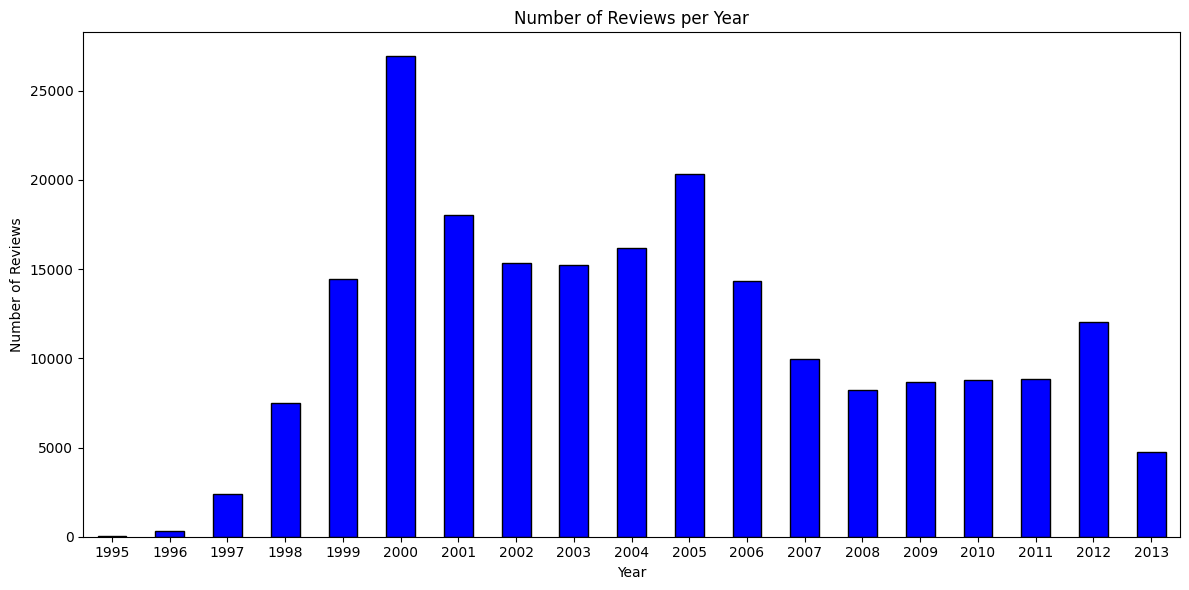

In [20]:
# Bar Plot of number of reviews per year
plt.figure(figsize=(12, 6))
reviews_books['review/year'].value_counts().sort_index().plot(kind='bar', color='blue', edgecolor='black')
plt.title('Number of Reviews per Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

> This bar chart illustrates the annual distribution of published reviews over time. A notable peak is observed from the late 1990s to the early 2000s, followed by a decline, and then a resurgence in 2012 and 2013. This fluctuation may be indicative of shifting trends in reviewing habits, alterations in data collection methodologies, or changes in the landscape of book publishing and reviewing practices.

#### 2. Histograms of Review Scores and Sentiment Scores

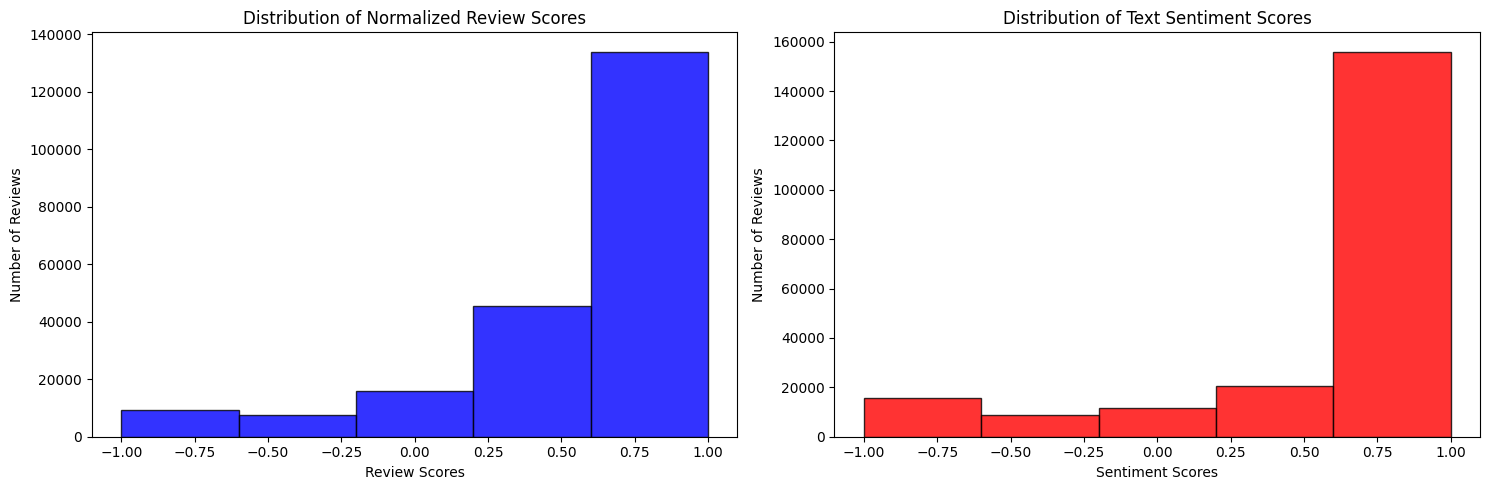

In [21]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of normalized review score
axs[0].hist(reviews_books['review/score_norm'], bins=5, edgecolor='black', color='blue', alpha=0.8)
axs[0].set_title('Distribution of Normalized Review Scores')
axs[0].set_xlabel('Review Scores')
axs[0].set_ylabel('Number of Reviews')

# Histogram of text sentiment score
axs[1].hist(reviews_books['sentiment_score_text'], bins=5, edgecolor='black', color='red', alpha=0.8)
axs[1].set_title('Distribution of Text Sentiment Scores')
axs[1].set_xlabel('Sentiment Scores')
axs[1].set_ylabel('Number of Reviews')

plt.tight_layout()
plt.show()

> The histograms illustrate the frequency distribution of `review/score_norm` and `sentiment_score_text`. Both distributions exhibit a skew towards higher scores, with a peak around score 1 being the most prevalent. This observation implies that reviewers predominantly assign positive ratings, indicating either a tendency to provide favorable reviews or a potential selection bias favoring positive evaluations of books.

#### 3. Bar Plots of Mean Review Scores and Sentiment Scores by Book Category

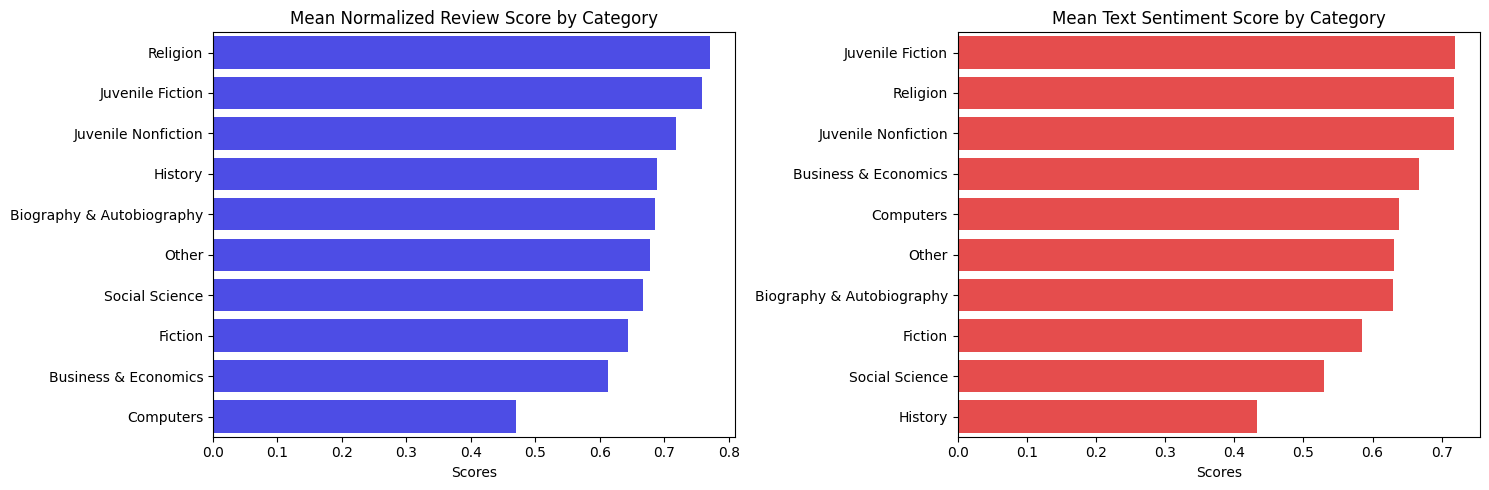

In [22]:
# Grouping by categories and calculating the mean of review/score_norm, sentiment_score_text, and sentiment_score_summary
review_score_mean = reviews_books.groupby('categories')['review/score_norm'].mean().reset_index().sort_values('review/score_norm', ascending=False)
sentiment_text_mean = reviews_books.groupby('categories')['sentiment_score_text'].mean().reset_index().sort_values('sentiment_score_text', ascending=False)

# Creating a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plotting the barplots
sns.barplot(data=review_score_mean, x='review/score_norm', y='categories', color='blue', alpha=0.8, ax=axs[0])
sns.barplot(data=sentiment_text_mean, x='sentiment_score_text', y='categories', color='red', alpha=0.8, ax=axs[1])
axs[0].set_title('Mean Normalized Review Score by Category')
axs[0].set_xlabel('Scores')
axs[0].set_ylabel('')
axs[1].set_title('Mean Text Sentiment Score by Category')
axs[1].set_xlabel('Scores')
axs[1].set_ylabel('')
plt.tight_layout()
plt.show()

> The bar charts illustrate the mean review score and sentiment score across various book categories. Notably, categories like *Religion*, *Juvenile Fiction*, and *Juvenile Nonfiction* exhibit the highest averages in both scores, implying a tendency towards more positive reviews within these genres. Conversely, the *Computer* category shows the lowest average review score despite a relatively higher sentiment score, suggesting potential discrepancies between objective evaluations and subjective sentiments. Additionally, while *History* demonstrates a higher mean review score, it achieves the lowest sentiment score among the categories analyzed.

#### 4. Box Plot of Sentiment Scores by Review Scores

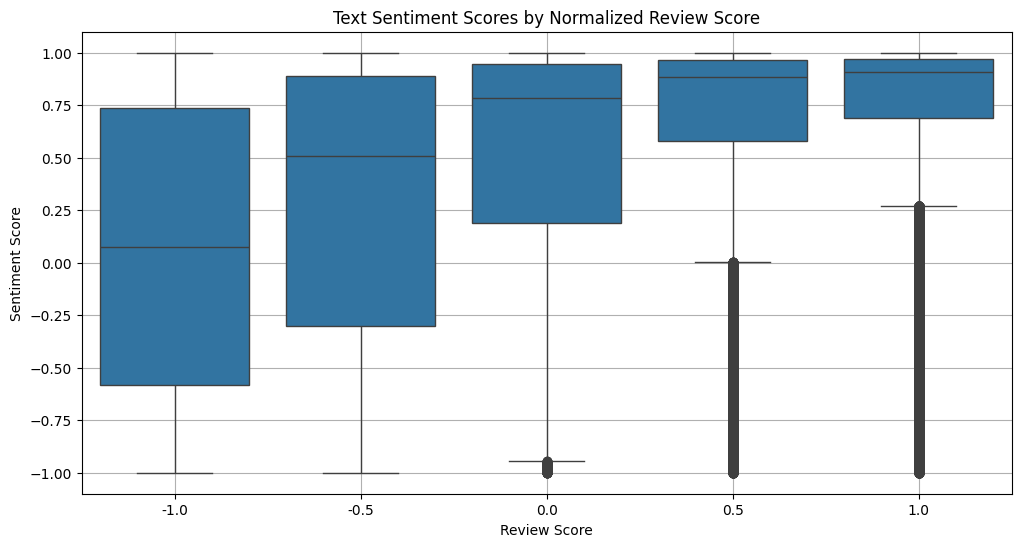

In [23]:
#Box plot of review_score and sentiment_score
plt.figure(figsize=(12, 6))
sns.boxplot(x='review/score_norm', y='sentiment_score_text', data=reviews_books)
plt.title('Text Sentiment Scores by Normalized Review Score')
plt.xlabel('Review Score')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.tight_layout()
plt.show()

> The box plot reveals a significant correlation between `review/score_norm` and `sentiment_score_text`, indicating that higher review scores tend to correspond with more positive sentiment in the reviews. However, notable outliers are observed in categories where review scores exceed zero, indicating reviews with exceptionally high sentiment scores compared to the norm. Particularly, the *interquartile range* (IQR) for 1-star reviews exhibits considerable breadth, suggesting a prevalence of negative sentiment. As the review score increases, the IQR shifts upward, reflecting a transition towards more positive sentiments associated with higher scores.

#### 5. Scatter Plot of Review Helpfulness and Sentiment Score

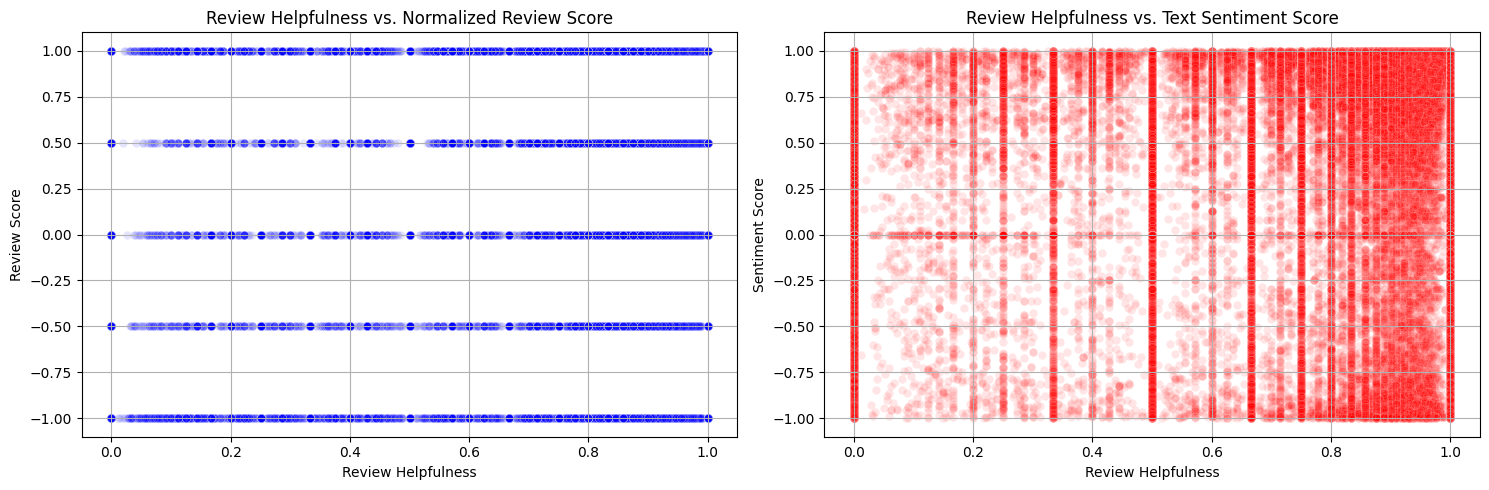

In [24]:
# Creating a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot of review/helpfulness and review score
sns.scatterplot(x='review/helpfulness', y='review/score_norm', data=reviews_books, color='blue', alpha=0.1, ax=axs[0])
axs[0].set_title('Review Helpfulness vs. Normalized Review Score')
axs[0].set_xlabel('Review Helpfulness')
axs[0].set_ylabel('Review Score')
axs[0].grid(True)

# Scatter plot of review/helpfulness and sentiment_score_text
sns.scatterplot(x='review/helpfulness', y='sentiment_score_text', data=reviews_books, color='red', alpha=0.1, ax=axs[1])
axs[1].set_title('Review Helpfulness vs. Text Sentiment Score')
axs[1].set_xlabel('Review Helpfulness')
axs[1].set_ylabel('Sentiment Score')
axs[1].grid(True)

plt.tight_layout()
plt.show()

> The presence of horizontal lines at specific review scores in the left plot suggests that reviewers tend to provide feedback in discrete categories, possibly influenced by the platform's rating system or guidelines, resulting in clustered data points at these values. On the other hand, the vertical lines pattern observed in the right plot indicates that sentiment scores tend to cluster around certain values for different levels of review `helpfulness`. However, there is no clear trend or correlation between the sentiment score and the review helpfulness.This suggests that the sentiment of the review content may not strongly influence how helpful other users find the review. The plot exhibits denser clusters at the upper and lower end of the helpfulness scale, indicating that reviews are often rated as very helpful. Additionally, a substantial density is observed around the middle sentiment score, suggesting a prevalence of reviews with neutral sentiment, yet still perceived as useful by other users.

#### 6. Heatmap of Sentiment Scores by Review Helpfulness and Review Scores

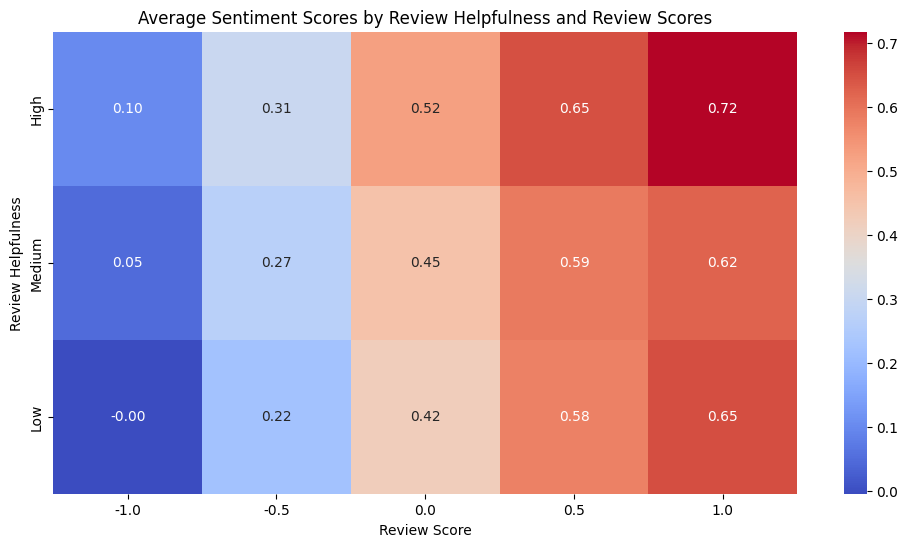

In [25]:
# Creating bins for review/helpfulness
reviews_books['helpfulness_bin'] = pd.cut(reviews_books['review/helpfulness'], bins=3, labels=['Low', 'Medium', 'High'])

# Creating a pivot table to analyze the relationship between review helpfulness, review score, and sentiment score
score_helpfulness = reviews_books.pivot_table(index='helpfulness_bin', columns='review/score_norm', values='sentiment_score_text', aggfunc='mean')

# Reverse the order of the labels on the y-axis
score_helpfulness = score_helpfulness[::-1]

# Plotting the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(score_helpfulness, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Average Sentiment Scores by Review Helpfulness and Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Review Helpfulness')
plt.tight_layout()
plt.show()

> The heatmap illustrates the average sentiment scores across various bins of review `helpfulness` and `review scores`. It's evident that higher review scores are typically associated with higher sentiment scores. A discernible trend emerges from the lower left to the upper right corner, suggesting a positive correlation between sentiment scores and both review score and helpfulness levels.

## Comparative Analysis

#### 1. Comparison of Review Scores and Sentiment Scores Across Different Book Categories

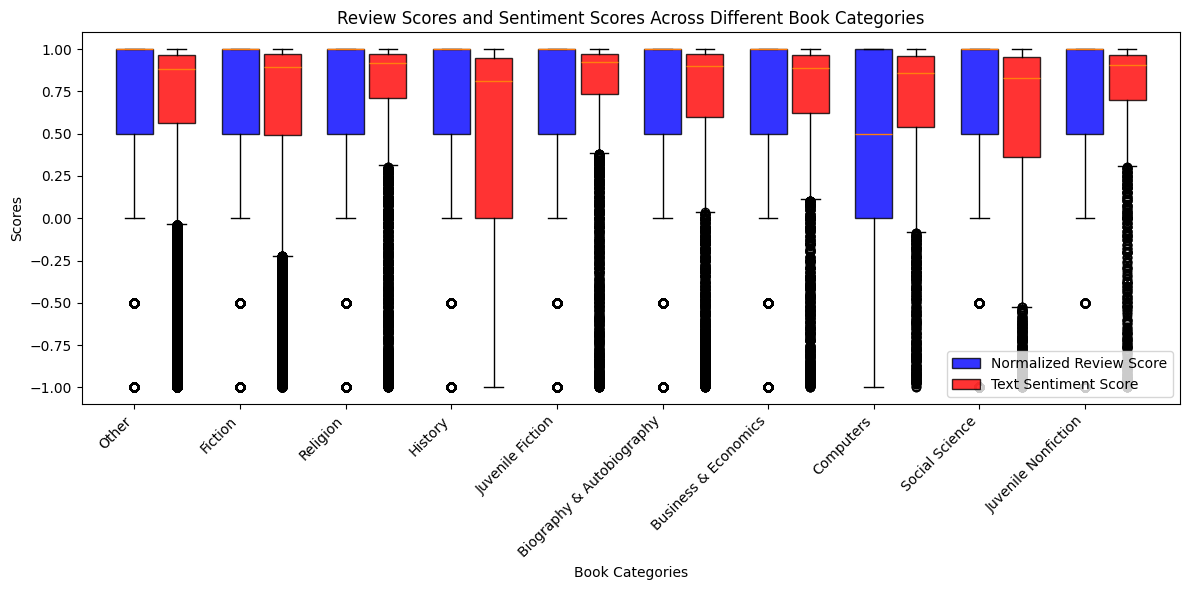

In [26]:
# Use list comprehension with re.sub() to replace 'Unknown' with 'Other'
top_categories = [re.sub(r'Unknown', 'Other', cat) for cat in top_categories]

# Define the sentiment scores and review scores
review_scores = [reviews_books[reviews_books['categories'] == cat]['review/score_norm'] for cat in top_categories]
sentiment_scores = [reviews_books[reviews_books['categories'] == cat]['sentiment_score_text'] for cat in top_categories]

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot review scores
review_boxes = ax.boxplot(review_scores, positions=range(len(top_categories)), widths=0.35, patch_artist=True, boxprops=dict(facecolor='blue', alpha=0.8))

# Plot sentiment scores
sentiment_boxes = ax.boxplot(sentiment_scores, positions=[x + 0.4 for x in range(len(top_categories))], widths=0.35, patch_artist=True, boxprops=dict(facecolor='red', alpha=0.8))

ax.set_xticks(range(len(top_categories)))
ax.set_xticklabels(top_categories, rotation=45, ha='right')
ax.legend([review_boxes['boxes'][0], sentiment_boxes['boxes'][0]], ['Normalized Review Score', 'Text Sentiment Score'], loc='lower right')
ax.set_xlabel('Book Categories')
ax.set_ylabel('Scores')
ax.set_title('Review Scores and Sentiment Scores Across Different Book Categories')
plt.tight_layout()
plt.show()

> From the box plot above, we observe notable discrepancies between the sentiment scores and normalized review scores across different categories. In the *History* category, there is a larger deviation in text sentiment scores compared to the normalized review scores. Conversely, in the *Computer* category, we observe higher volatility in the normalized review scores relative to the sentiment scores. These differences suggest that there may be varying factors influencing the sentiment conveyed in reviews compared to the overall rating of books, particularly in the domains of history and computer literature.

#### 2. Comparison of Sentiment Scores and Review Scores Over Time

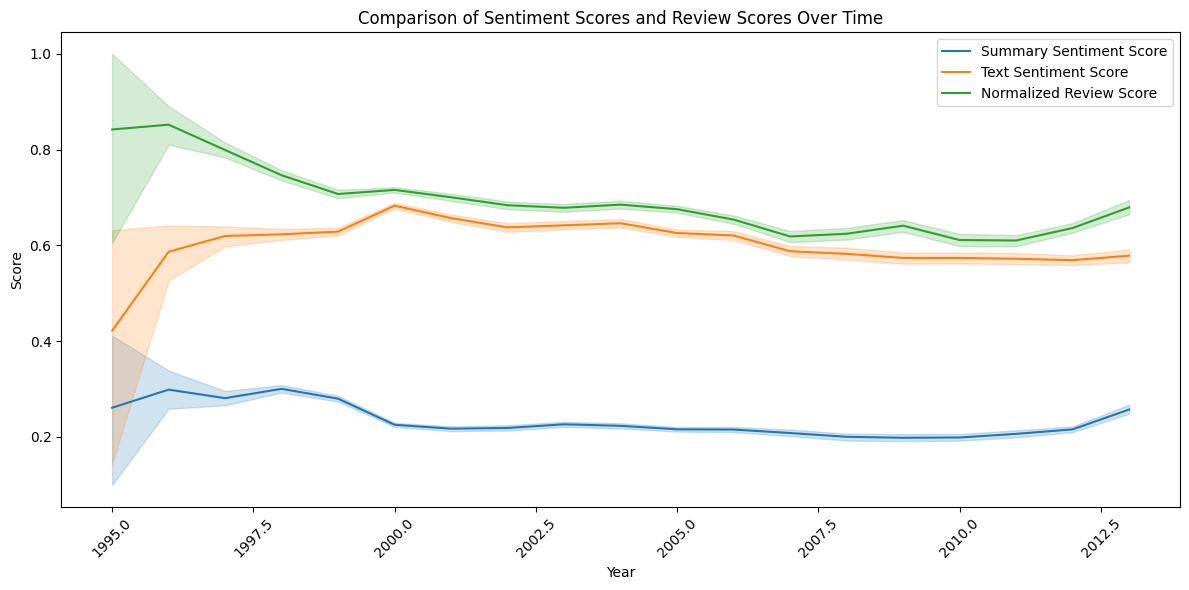

In [27]:
# Convert 'review/year' to datetime format
reviews_books['review/year'] = pd.to_datetime(reviews_books['review/year'], format='%Y').dt.year

# Plotting sentiment scores over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=reviews_books, x='review/year', y='sentiment_score_summary', label='Summary Sentiment Score')
sns.lineplot(data=reviews_books, x='review/year', y='sentiment_score_text', label='Text Sentiment Score')
sns.lineplot(data=reviews_books, x='review/year', y='review/score_norm', label='Normalized Review Score')
plt.title('Comparison of Sentiment Scores and Review Scores Over Time')
plt.xlabel('Year')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


> The line plot above highlights similar trends in sentiment and review scores over time. Interestingly, while the normalized review score exhibits the highest average score across the years, the summary sentiment score consistently records the lowest mean values. This discrepancy implies that, despite the overall positive review scores, the sentiment conveyed in the summarized reviews tends to be less favorable.

#### 3. Counts of Reviews in Each Category Over Time Across Different Review Scores

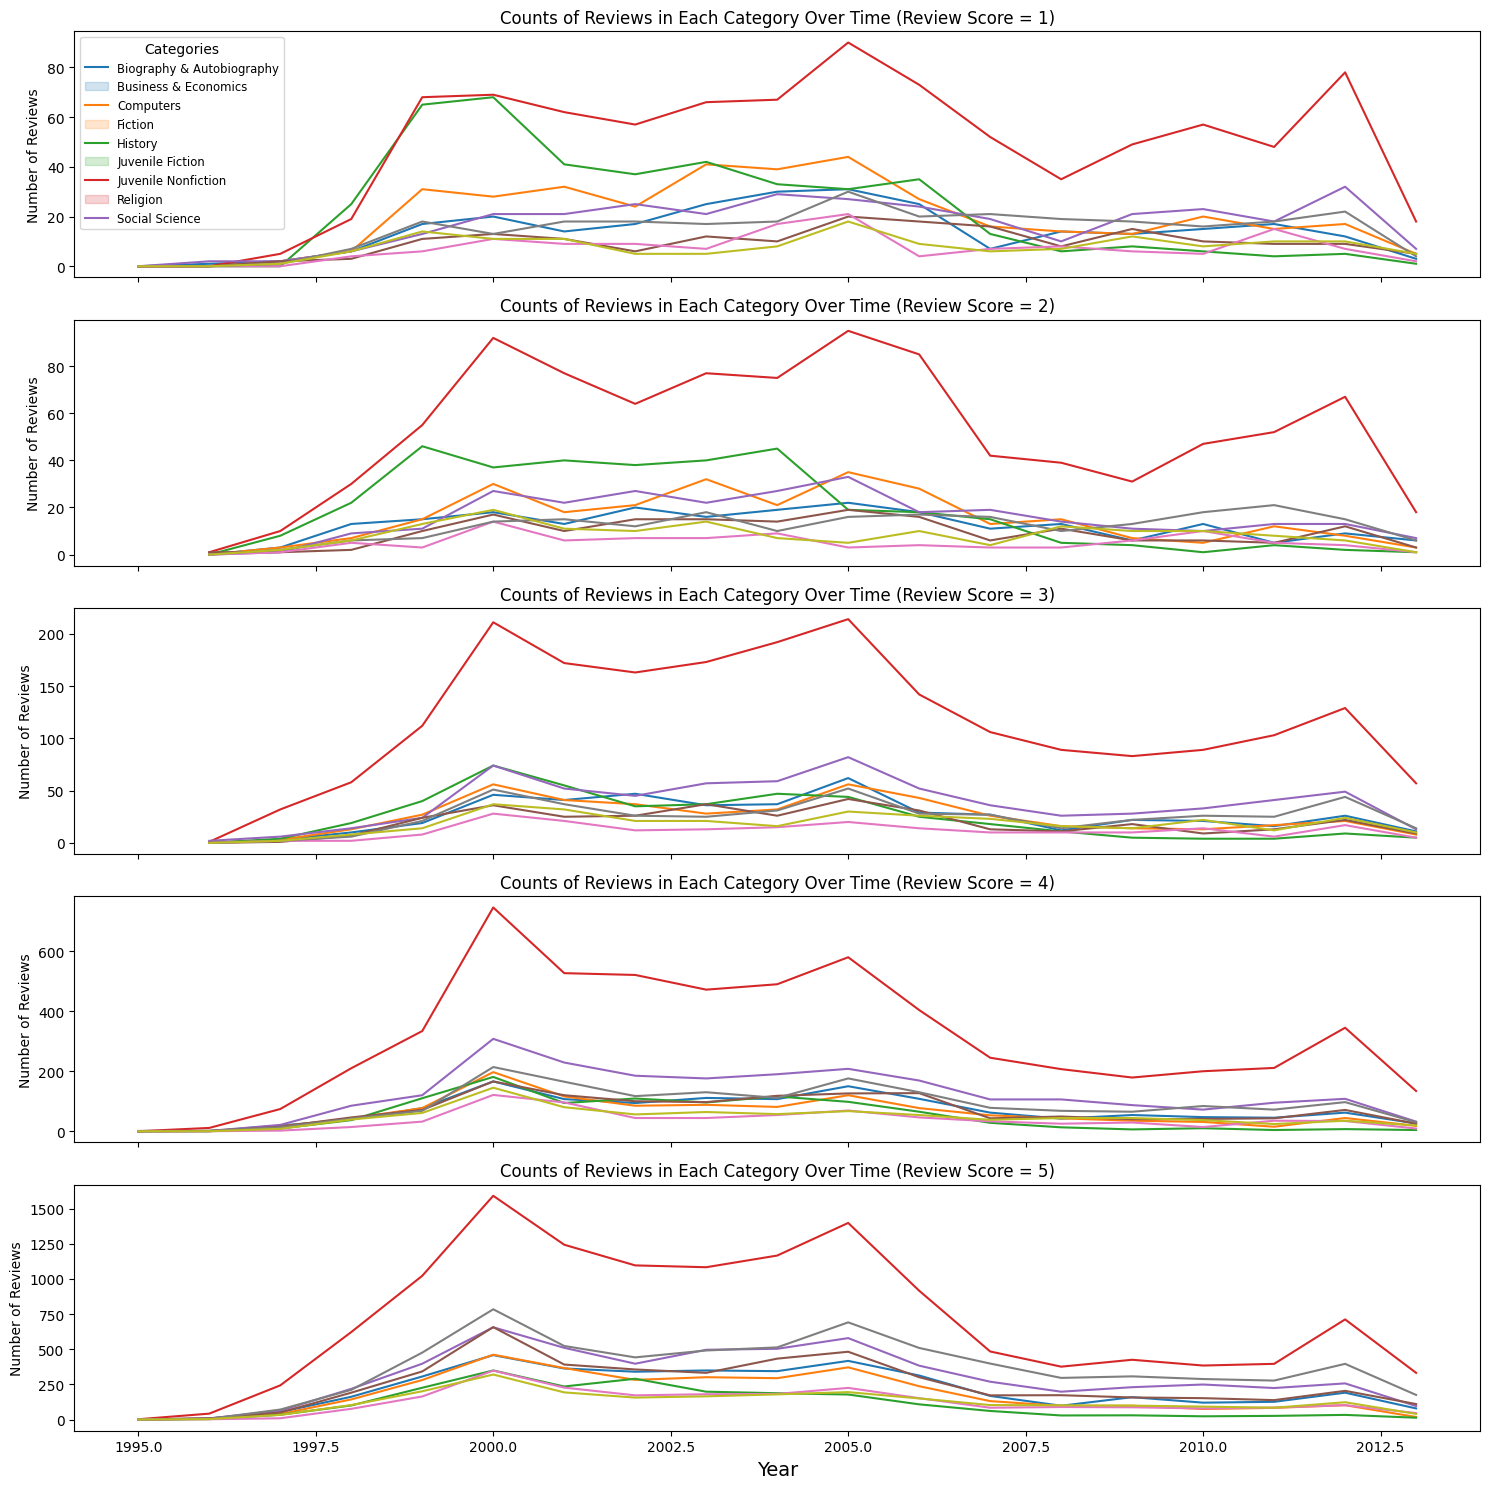

In [28]:
# Define the review scores
review_scores = [1, 2, 3, 4, 5]

# Create subplots
fig, axes = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

# Initialize legend
legend_labels = []

# Iterate through each review score
for i, score in enumerate(review_scores, 1):
    # Filter the dataframe for the current review score
    subset_df = reviews_books[reviews_books['review/score'] == score]

    # Create a pivot table to get counts of reviews in each category for each year
    pivot_table_year_category = subset_df.pivot_table(index='review/year', columns='categories', aggfunc='size', fill_value=0).drop(columns=['Other'])

    # Reshape the pivot table to tidy format
    pivot_table_year_category_tidy = pivot_table_year_category.reset_index().melt(id_vars='review/year', var_name='Category', value_name='Review Count')

    # Plot the counts over time using Seaborn
    sns.lineplot(data=pivot_table_year_category_tidy, x='review/year', y='Review Count', hue='Category', ax=axes[i-1], legend=False)

    # Add labels to legend
    if i == 1:
        for label in pivot_table_year_category.columns:
            legend_labels.append(label)

    # Set title and y-label for each subplot
    axes[i-1].set_title(f'Counts of Reviews in Each Category Over Time (Review Score = {score})')
    axes[i-1].set_ylabel('Number of Reviews')

# Add single legend
axes[0].legend(legend_labels, loc='upper left', title='Categories', fontsize='small')

# Set common x-label
plt.xlabel('Year', fontsize=14)
plt.tight_layout()
plt.show()

> The time plots above reveal insightful trends across various genres and review scores. *Fiction* emerges as the most frequently reviewed genre, highlighting readers' keen interest in novels within this category. Notably, recent years have witnessed a surge in higher review scores, suggesting a potential elevation in book quality or a more positive reception from readers. Among other genres like *Biography & Autobiography*, *Business & Economics*, *Computers*, *History*, and *Religion*, reviews are distributed fairly across different score levels, with a noticeable uptick in feedback as scores improve. Similarly, *Juvenile fiction* and *Juvenile nonfiction* categories exhibit concentrated reviews at higher score levels, indicating readers' favorable perceptions of children's literature. Additionally, the *Social Science* category sees a gradual increase in reviews with rising score levels, reflecting readers' generally positive opinions toward books in this domain.

## Multivariate Analysis

#### 1. Correlation Analysis

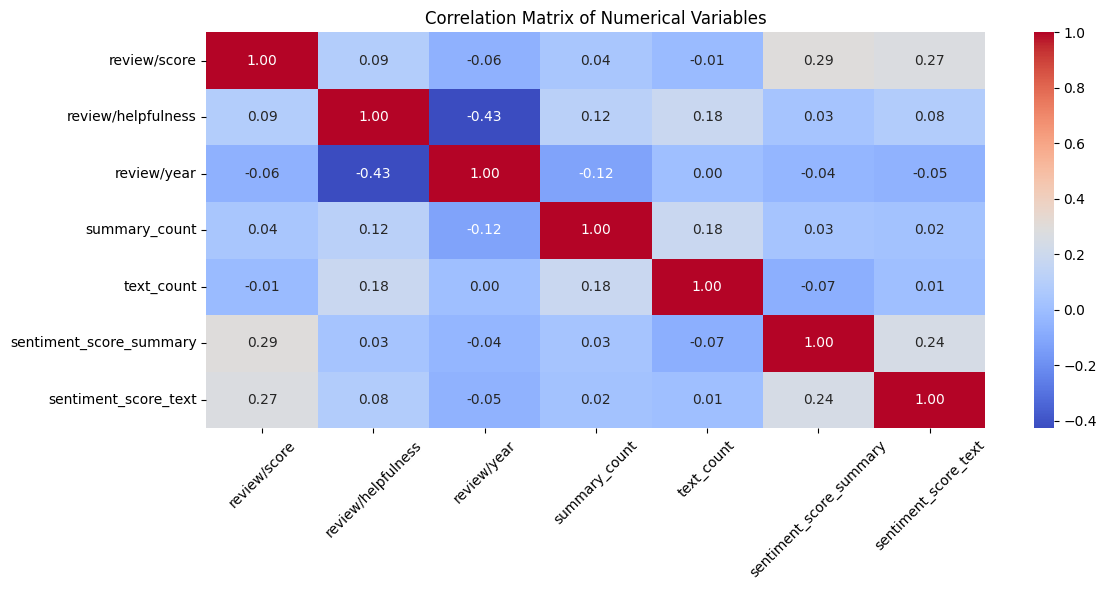

In [29]:
# Compute correlation matrix for numerical variables
correlation_matrix = reviews_books[['review/score', 'review/helpfulness', 'review/year', 'summary_count', 'text_count', 'sentiment_score_summary', 'sentiment_score_text']].corr()

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Variables')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

> The correlation analysis reveals several noteworthy relationships within the dataset. Firstly, there exists a moderate positive correlation between `review/score` and both `sentiment_score_summary` (0.294) and `sentiment_score_text` (0.272). This implies that higher review scores often coincide with more positive sentiment scores, suggesting a tendency for positively rated reviews to exhibit favorable sentiments. Conversely, a weak negative correlation is observed between `review/year` and `review/helpfulness` (-0.426), indicating that over time, reviews are perceived as less helpful. Additionally, there are weak positive correlations between `summary_count` and `text_count` with `review/helpfulness` and `sentiment_score_summary`, suggesting that longer summaries and texts may contribute to higher perceived helpfulness and more positive sentiment. These findings shed light on the interplay between review scores, sentiment, and other factors such as review age and length, providing insights into reviewer behavior and perception over time.

#### 2. Book Category Preferences of Top 10 Authors

In [30]:
# Create the cross-tabulation
top_authors = reviews_books['authors'].value_counts().head(10).index.tolist()
pd.crosstab(reviews_books['categories'], reviews_books['authors'])[top_authors]

authors                     Other  Rose Arny  William Shakespeare  \
categories                                                          
Biography & Autobiography    6323          0                    0   
Business & Economics         5625          0                    0   
Computers                    4312          0                    0   
Fiction                     23190          0                    2   
History                      9328          0                    0   
Juvenile Fiction             6626          0                    1   
Juvenile Nonfiction          3442          0                    2   
Other                      139069        236                  186   
Religion                     9459          0                    0   
Social Science               3834          0                    0   

authors                    Library of Congress. Copyright Office  \
categories                                                         
Biography & Autobiography                                      0   
Business & Economics                                           0   
Computers                                                      0   
Fiction                                                        0   
History                                                        0   
Juvenile Fiction                                               0   
Juvenile Nonfiction                                            0   
Other                                                        178   
Religion                                                       0   
Social Science                                                 0   

authors                    Agatha Christie  Erle Stanley Gardner  \
categories                                                         
Biography & Autobiography                1                     0   
Business & Economics                     0                     0   
Computers                                0                     0   
Fiction                                 76                    24   
History                                  0                     0   
Juvenile Fiction                         0                     0   
Juvenile Nonfiction                      0                     0   
Other                                   65                   100   
Religion                                 0                     0   
Social Science                           0                     0   

authors                    Charles Dickens  Edgar Rice Burroughs  Zane Grey  \
categories                                                                    
Biography & Autobiography                0                     0          0   
Business & Economics                     0                     0          0   
Computers                                0                     0          0   
Fiction                                 21                    48         40   
History                                  1                     1          0   
Juvenile Fiction                         2                     1          0   
Juvenile Nonfiction                      0                     1          0   
Other                                   65                    34         35   
Religion                                 0                     0          0   
Social Science                           0                     0          0   

authors                    Rudyard Kipling  
categories                                  
Biography & Autobiography                0  
Business & Economics                     0  
Computers                                0  
Fiction                                 18  
History                                  0  
Juvenile Fiction                        13  
Juvenile Nonfiction                      1  
Other                                   43  
Religion                                 0  
Social Science                           0

> The top 3 authors, namely *Rose Arny*, *William Shakespeare*, and *Library of Congress*, are primarily associated with the *Other* category for their book publications. Additionally, authors like *Agatha Christie*, *Erle Stanley Gardner*, and *Charles Dickens* exhibit a tendency to write across multiple categories, notably *Fiction* and *Other*. Conversely, authors such as *Edgar Rice Burroughs*, *Zane Grey*, and *Rudyard Kipling* display a diverse range of category preferences, encompassing genres like *Fiction* and *Juvenile Fiction*.

#### 3. Book Category Preferences of Top 10 Publishers

In [31]:
# Create the cross-tabulation
top_publishers = reviews_books['publisher'].value_counts().head(10).index.tolist()
pd.crosstab(reviews_books['categories'], reviews_books['publisher'])[top_publishers]

publisher                   Other  Simon and Schuster  Penguin  Routledge  \
categories                                                                  
Biography & Autobiography    5512                 321      120         14   
Business & Economics         4437                 121      100        221   
Computers                    3894                   6       12          3   
Fiction                     19813                 901     1114          4   
History                      8114                 184       91        341   
Juvenile Fiction             5487                 453      259          0   
Juvenile Nonfiction          3061                  74       89          0   
Other                      132467                1231      956       1412   
Religion                     8967                 113       47         68   
Social Science               3206                  50       37        331   

publisher                  John Wiley & Sons  Harper Collins  \
categories                                                     
Biography & Autobiography                  6              84   
Business & Economics                     572              55   
Computers                                351               3   
Fiction                                    0             611   
History                                   28              79   
Juvenile Fiction                           0             291   
Juvenile Nonfiction                        8              53   
Other                                    993             548   
Religion                                  39             142   
Social Science                            34              45   

publisher                  Cambridge University Press  Macmillan  \
categories                                                         
Biography & Autobiography                          20        122   
Business & Economics                               90         19   
Computers                                          42          1   
Fiction                                             5        497   
History                                           280         54   
Juvenile Fiction                                    1         97   
Juvenile Nonfiction                                19         38   
Other                                             928        375   
Religion                                           55          6   
Social Science                                     46         15   

publisher                  Courier Corporation  Vintage  
categories                                               
Biography & Autobiography                   12      113  
Business & Economics                         3        7  
Computers                                    0        0  
Fiction                                     86      388  
History                                     53      106  
Juvenile Fiction                            53        2  
Juvenile Nonfiction                        104        0  
Other                                      783      318  
Religion                                     5       17  
Social Science                              17       53

> The top 2 publishers, *Simon and Schuster*, and *Penguin*, predominantly specialize in publishing books within the *Fiction* and *Juvenile Fiction* categories. *John Wiley & Sons* primarily focuses on *Business & Economics* and *Computers* categories, reflecting their specialization in academic and technical publications. *Cambridge University Press* is notable for its emphasis on the *History* category, aligning with its reputation as a scholarly publisher in the field of humanities.

#### 4. Pairwise Scatter Plot Matrix of Review Attributes

<Figure size 1200x600 with 0 Axes>

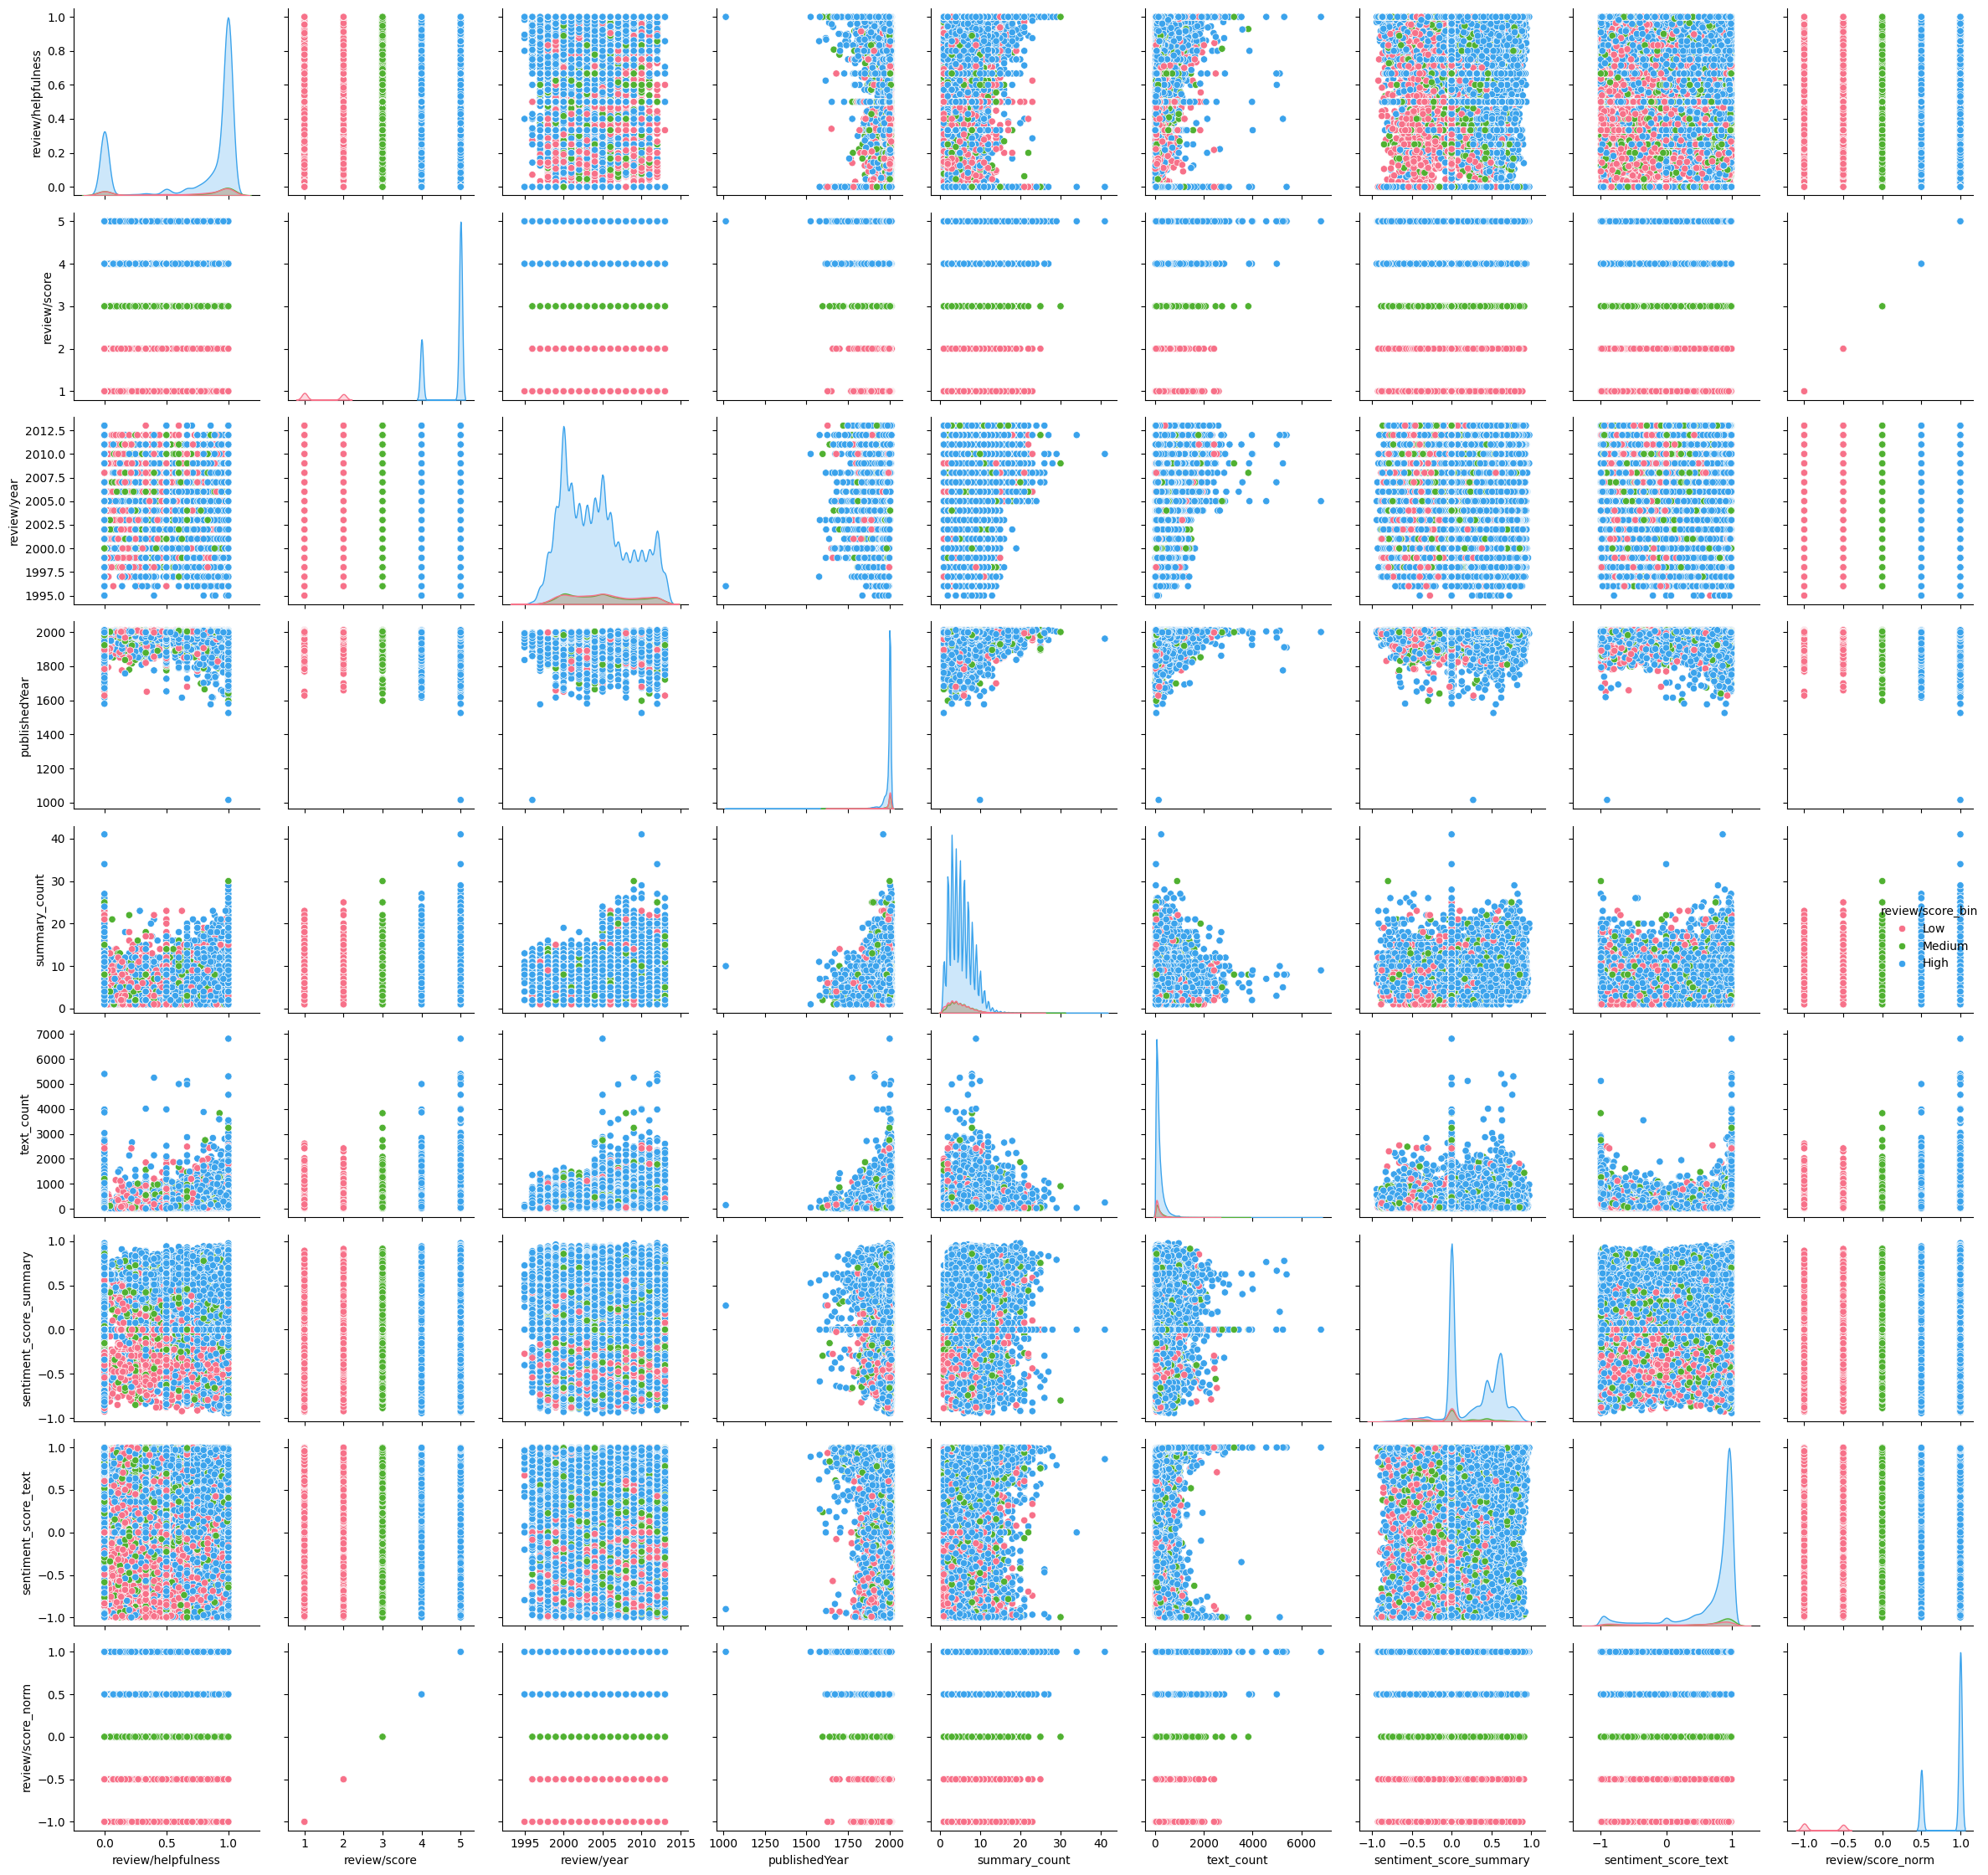

In [32]:
# Creating bins for review/helpfulness
reviews_books['review/score_bin'] = pd.cut(reviews_books['review/score'], bins=3, labels=['Low', 'Medium', 'High'])

# Scatter plot matrix to visualize relationships among multiple numerical variables
plt.figure(figsize=(12, 6))
sns.pairplot(reviews_books, hue='review/score_bin', diag_kind='kde', palette='husl')
plt.tight_layout()
plt.show()

> The pairplot visualizes the relationships among multiple numerical variables, with the data points colored based on the binned review score (*Low*, *Medium*, *High*). The KDE plots reveal the density of data points for each bin of the review score, providing insights into the distribution of scores within each category. Notably, the distributions of the *High* category differ from the other two categories, suggesting potential distinctions that could be leveraged in subsequent analyses such as classification and clustering. This disparity in distributions hints at nuanced patterns within the data that may be indicative of varying trends or characteristics among reviews with high scores. Moreover, the distribution of `publishedYear` is notably centered around the year 2000, suggesting a concentration of published works during that period. Meanwhile, `Review/year` data appears to be more evenly spread, with a higher frequency observed between 2005 and 2015. Additionally, the majority of `review/score` tend to be 5 stars. Moreover, the `summary_count` variable is predominantly clustered within the range of 0 to 15.

## Synthesis

- #### Findings Synthesizing

> Summarizing from our analyses above, it's evident that most reviews skew towards higher scores, suggesting a prevailing positive sentiment among reviewers. Interestingly, we noted weak negative correlations between review helpfulness and review year, suggesting a decline in review helpfulness over time. While higher review scores generally correlated with more positive sentiments, outliers and fluctuations within the data highlighted nuances in this relationship. Notably, categories like *Computer* and *History* exhibited a divergent pattern between sentiment scores and review scores, indicating potential complexities in reader perceptions within these categories.



- #### Added Value of Combined Datasets

> By integrating the `books` dataset with the `reviews` dataset, we expanded the scope of our analysis and unearthed intricate relationships that transcend individual datasets. This integration empowered us to delve into authorship, book categorization, and publisher dynamics within the context of reviews, providing a holistic view of the factors influencing review scores and sentiments. Our exploration illuminated the interplay between these variables, offering valuable insights for publishers, authors, and retailers seeking to refine their marketing, promotional, and content strategies.

## Reflection

- #### Challenges

> When delving into the graphical analysis of Amazon book reviews, we encountered the challenge of effectively visualizing large datasets, particularly due to overplotting. This issue, where an excessive number of data points overlap, can significantly hinder our ability to identify underlying patterns, a situation that's especially problematic in visualizations like the box plot for review helpfulness and sentiment score. To tackle this challenge, we employed alpha blending techniques, adjusting the transparency of data points to diminish visual clutter. This approach proved to be highly effective, significantly enhancing the clarity of the visual representation and facilitating a more intuitive understanding of the data's patterns and trends.

>In multivariate analysis, when attempting to create pivot tables to explore the relationships among variables such as review/year, authors, categories, and review/helpfulness, we encountered difficulties. Since each author cannot publish books in the same field and year, there were numerous NaN values in the resulting pivot tables, making it challenging to discern meaningful relationships. Consequently, we had to discard such charts as they obscured the relationships among other variables due to the dominance of NaN data. This highlights the importance of carefully considering the structure of the data and the potential impact of missing values on the analysis outcomes.

- #### Limitations

> One significant limitation of the current graphical analysis, particularly evident in the visualization of Review Scores vs. Helpfulness, is the potential loss of important details or nuances due to data aggregation. In an attempt to make the data more visually digestible, we aggregated it into bins. While this approach is useful for simplifying complex datasets and highlighting general trends, it unfortunately obscures outliers or variations within the data. These outliers or variations often hold critical insights or indicate exceptions to the general trends, providing valuable context that can lead to a deeper understanding of the dataset.

> A promising direction for further research or improvement involves the development of interactive charts. Unlike static visualizations, interactive charts offer users the flexibility to explore the data in more depth and at their own pace. By utilizing tools such as Bokeh or Plotly, it becomes possible to create visualizations that support zooming, filtering, and detailed examination through tooltips or hover-over points. This level of interactivity not only mitigates the limitation of losing detail through aggregation but also enhances user engagement with the data. Users can tailor the visualization to their interests or focus areas, uncovering patterns or insights that static visualizations might not readily reveal. Through interactive visualizations, we can provide a more nuanced and comprehensive view of the Amazon book reviews dataset, empowering users to derive their own insights and conclusions.

> Regarding multivariate analysis, there may be a better way of presenting the relationship among review/year, authors, categories, and review/helpfulness. Models with three or fewer variables can be effectively employed, but when dealing with a larger number of variables, it may be necessary to explore more advanced methods or visualization techniques to capture the complexity of the relationships accurately. Further research could focus on identifying and implementing these methods to provide more comprehensive insights into the interplay between multiple variables in the dataset.